In [1]:
import drjit as dr
import mitsuba as mi
import numpy as np

import os
import pickle
import tqdm
import time
# import torch

from scipy.spatial.transform import Rotation as R

In [2]:
variant = 'llvm_ad_rgb'

In [3]:
mi.set_variant(variant)

### Hyper-parameters

These parameters were set for the woven patterns shared by Cem Yuksel

In [4]:
pattern_file = './dataset/wovenpatterns/datafiles/satin2_3_0.027.txt'

backlight = True

max_depth = 5 # Max Depth For Path Tracer (2 for single yarn, 4 for cloth sample)
rad = 2. # Yarn Radius
# sigma = 5.5 # Sigma For Attenuation of Specular Y
sigma = 10.5 # Sigma For Attenuation of Specular Y # Sweater
sigma_d = 0.1 # Sigma For Attenuation of Specular Y # Basket
sigma_d = 0.125 # Sigma For Attenuation of Specular Y # Satin
sigma_d = 0.3 # Sigma For Attenuation of Specular Y # Sweater
tt_weight = 1.1 # Sampling Weight For Specular Y vs Diffuse Y (Set to 1.1 to ensure only Specular Y is sampled)
scale_V = 20 # V varies from 0 to 1 so change it to 0 to scale

'''Ply Parameters'''
# Plies are always assumed to be uniformly distributed
res = 1000 # Size of 1D Textures
num_ply = 5
ply_rad = 0.9
ply_origin = ply_rad / np.sin(np.pi*2/(num_ply*2))
ply_twist = 1/3

'''Fiber Parameters'''
# These parameters are for generating a uniform fiber-cross section
res = 1000 # Size of 1D Textures
num_fibers = 40
fiber_rad = 1 / np.sqrt(50)
fiber_twist = -1.5
fiber_origin = fiber_rad / np.sin(np.pi*2/(num_fibers*2))

# Basket and Satin
shadow_thr = 0.3 # Adjust AO to make it between n to 1 instead of 0 to 1
ply_shadow_thr = 0.01 # Adjust AO to make it between n to 1 instead of 0 to 1


'''BSDF Parameters'''
m_eta = 1.5 # Refractive Index of Cloth Sample
m_r = 0.5 # Ratio between Body X and Body Y

# Satin
specx_alphau = 0.2
specx_alphav = 0.3

# Satin
specx_color = np.array([0.875, 0.875, 0.875])

# # Basket
# specx_alphau = 0.5
# specx_alphav = 0.5

# # Basket
# specx_color = np.array([0.175, 0.175, 0.175])

# Knit
# specx_alphau = 0.4
# specx_alphav = 0.4
# specx_color = np.array([0.875, 0.0, 0.0])

# Same For All
specy_alphau = 0.9
specy_alphav = 0.9
specy_color = [0.1, 0.1, 0.1]


# diff_color = np.array([0.15, 0.03, 0.03])
# diff_color = np.array([0.01, 0.05, 0.04])
# diff_color = np.array([0.02, 0.04, 0.05])
# diff_color_y = np.array([0.05, 0.001, 0.005])
# diff_color = np.array([0.05, 0.00, 0.35])
# diff_color = np.array([0.08, 0.003, 0.08])

# Glove
# diff_color = [0.045, 0.045, 0]

# # Satin
diff_color_x = np.array([1.0, 0.0, 0.0])
diff_color_y = np.array([1.0, 0.0, 0.0])

# # Basket
# diff_color_x = np.array([0.01, 0.00, 0.05])
# diff_color_y = np.array([0.01, 0.00, 0.05])

# Knit
# diff_color_x = np.array([0.075, 0.001, 0.01])
# diff_color_y = np.array([0.075, 0.001, 0.01])

print(ply_origin)
print(fiber_origin)

1.531171455033672
1.8024851666384858


### Scene Setup

In [5]:
scene_dict = {
    'type': 'scene',
    'integrator': { 
        'type': 'mydirectintegrator' 
    },
    # 'lightf': {
    #     'type': 'directional',
    #     'direction': [0.0, -0.3162277638912201, -0.9486832618713379],
    #     'irradiance': {
    #         'type': 'rgb',
    #         'value': 1.0,
    #     },
    # },
    # 'light': {
    #     'type': 'sphere',
    #     'center': [140.0, 59.5, 178.5],
    #     'emitter': {
    #         'type': 'area',
    #         'radiance': {
    #             'type': 'rgb',
    #             'value': 10.0,
    #         }
    #     },
    # },
    
    # # Knit
    # 'light2': {
    #     'type': 'point',
    #     'position': [0.0, 80.0, 240.0],
    #     'intensity': {
    #         'type': 'rgb',
    #         'value': 1.0,
    #     },
    # },
    
    # # Woven Scene
    # 'light2': {
    #     'type': 'directional',
    #     'direction': [-1.0, 0.0, 4.0],
    #     'irradiance': {
    #         'type': 'rgb',
    #         'value': 1.0,
    #     },
    # },
    
    # 'light3': {
    #     'type': 'directional',
    #     'direction': [1.0, 0.0, -4.0],
    #     'irradiance': {
    #         'type': 'rgb',
    #         'value': 1.0,
    #     },
    # },
    
    # 'light1': {
    #     'type': 'directional',
    #     'direction': [-400.0, -170.0, -510.0],
    #     'irradiance': {
    #         'type': 'rgb',
    #         'value': 50.0,
    #     },
    # },
    
    'light1': {
        'type': 'sphere',
        'center': [660.0, 280.5, 841.5],
        'emitter': {
            'type': 'area',
            'radiance': {
                'type': 'rgb',
                'value': 1.0e12,
            }
        },
    },
    
    'light2': {
        'type': 'point',
        'position': np.array([16, 15.55, 7.55])*12.5,
        'intensity': {
            'type': 'rgb',
            'value': 600000.0,
        },
    },
    
    'light3': {
        'type': 'envmap',
        'filename': 'env.png'
        # 'filename': 'envmap.exr'
    },
    
    # 'diffuse': {
    #     'type': 'constant',
    #     'radiance': {
    #         'type': 'rgb',
    #         'value': 10.0,
    #     },
    # },

    # 'lightb': {
    #     'type': 'directional',
    #     'direction': [0.0, -2.0, -6.0],
    #     # 'direction': [1.0, 1.0, 1.0],
    #     'irradiance': {
    #         'type': 'rgb',
    #         'value': 1.0,
    #     },
    # },
    
    # # Glove
    'sensor': {
        'type': 'perspective',
        'to_world': mi.ScalarTransform4f.look_at(origin=[600, 255, 765], 
                                                 target=[0, 0, 0], 
                                                 up=[0, 1, 0]),
        # 'fov': 2.5
    },
    
    # 'sensor': {
    #     'type': 'perspective',
    #     'to_world': mi.ScalarTransform4f.look_at(origin=[0, 70, 210], 
    #                                              target=[0, 0, 0], 
    #                                              up=[0, 0, 1]),
    #     'fov': 20
    # }
    
    # # Woven
    # 'sensor': {
    #     'type': 'perspective',
    #     'to_world': mi.ScalarTransform4f.look_at(origin=[0, 100, 200], 
    #                                              target=[100, 100, -200], 
    #                                              up=[0, 0, 1]),
        # 'fov': 20,
    # }
}

In [6]:
def fixed_quat_to_matrix(q):
    q = q * dr.sqrt_two

    xx = q.x * q.x; yy = q.y * q.y; zz = q.z * q.z
    xy = q.x * q.y; xz = q.x * q.z; yz = q.y * q.z
    xw = q.x * q.w; yw = q.y * q.w; zw = q.z * q.w

    return mi.Matrix3f(
        1.0 - (yy + zz), xy - zw, xz + yw,
        xy + zw, 1.0 - (xx + zz), yz - xw,
        xz - yw,  yz + xw, 1.0 - (xx + yy)
    )

### Pattern File Reading

In [7]:
from RMF import *

In [8]:
def readWovenPattern(file_path, yarn_rad=2, point_scale_factor=100):
    '''Read Woven Pattern File'''
    f = open(file_path, 'r')

    for i, l in enumerate(f.readlines()):
        l = l.replace('\n', '')
        l = l.replace('\r', '')

        if len(l) == 0:
            continue

        if i == 0:
            num_yarns = int(l.split(' ')[-1])
            count_yarn = -1
        elif len(l.split(' ')) < 3:
            num_points = int(l)
            points_array = np.zeros((num_points, 3))
            if count_yarn == -1:
                points_array_list = []
            count_yarn += 1; count_points = 0
        else:
            point = l.split(' ')
            for j in range(len(point)):
                points_array[count_points, j] = float(point[j])
            count_points += 1
            if count_points == num_points:
                points_array_list.append(points_array)

    max_num = -1
    for i in range(len(points_array_list)):
        if max_num < points_array_list[i].shape[0]:
            max_num = points_array_list[i].shape[0]

    points_array = np.zeros((num_yarns, max_num,3))
    number_array = np.zeros(num_yarns).astype(np.int64)
    for i in range(len(points_array_list)):
        points_array[i,:points_array_list[i].shape[0],:] = np.copy(points_array_list[i])
        number_array[i] = points_array_list[i].shape[0]
    
    '''Rescale the points if needed'''
    point_list = points_array[:,:,:] * point_scale_factor
    
    '''Generate RMF Normals'''
    length_list = np.zeros(point_list.shape)
    normal_list = np.zeros(point_list.shape)
    length_sum = get_length_sum(point_list)

    for i in range(point_list.shape[0]):
        length_list[i] = get_length(point_list[i])

        next_point = np.zeros(point_list[i].shape)
        next_point[:point_list[i,1:-1].shape[0],:] = point_list[i,1:-1,:]

        tangents = next_point - point_list[i]
        tangents[-1] = tangents[-2]
        tangent_norm = np.linalg.norm(tangents, axis=1).reshape(tangents.shape[0], 1)
        tangents = tangents / (np.repeat(tangent_norm, 3, axis=1))

        normals = generateRMF(point_list[i], tangents)
        normal_list[i] = np.array(normals)    

    point_list_2 = np.zeros((point_list.shape[0], point_list.shape[1], point_list.shape[2]+4))
    point_list_2[:,:,:3] = point_list
    point_list_2[:,:,3:6] = normal_list
    point_list_2[:,:,6] = rad
    # point_list_2[:,:,3] = 2
    
    '''Save the generated points and normals as .txt'''
    if not os.path.exists('./tmp/'):
        os.makedirs('./tmp/')
    for i in range(point_list.shape[0]):
        np.savetxt('./tmp/{}_c_{}'.format(file_path.split('/')[-1], i), point_list_2[i])
    
    '''Return List of B-Spline Curves Corresponding To Each'''
    s = []
    for i in range(point_list.shape[0]):
        sh = {
                "type" : "bsplinecurve",
                "filename" : './tmp/{}_c_{}'.format(file_path.split('/')[-1], i),
            }
        s.append(sh)
        
    return s

In [9]:
# curve_list = readWovenPattern(pattern_file)

### Cross-Section

In [10]:
class CrossSectionFiberDist:
    def __init__(self, fiber_dist_beta, fiber_dist_eps):
        self.fiber_dist_beta = fiber_dist_beta
        self.fiber_dist_eps = fiber_dist_eps
        
    def sampleR(self):
        while True:
            rand = np.random.rand(); 
            radius = np.sqrt(rand); pdf = rand
            if ( pdf < self.fiberDistribution(radius)):
                return radius
            
    def sampleFiberLocation(self):
        r = 0
        theta = 0

        while (True):
            # Sampling the unit disk.
            u1 = np.random.rand()
            u2 = np.random.rand()
            r = np.sqrt(u1)
            theta = 2.0 * np.pi * u2

            # Rejection.
            ksi = np.random.rand()
            if ksi < 1:
                break

        return (r, theta)
    
    def fiberDistribution(self, R):
        eTerm = (np.exp(1) - np.power(np.exp(1), R)) / (np.exp(1) - 1)
        pR = (1 - 2 * self.fiber_dist_eps) * np.power(eTerm, self.fiber_dist_beta) + self.fiber_dist_eps
        return pR;

In [11]:
class CrossSection:
    def __init__(self, fiber_count, fiber_twist, fiber_dist_beta, fiber_dist_eps, fiber_radius, fiber_origin, ply_radius=1.1):
        self.ply_radius = ply_radius
        
        self.fiber_count = fiber_count
        self.fiber_twist = fiber_twist
        self.fiber_dist_beta = fiber_dist_beta
        self.fiber_dist_eps = fiber_dist_eps
        self.fiber_radius = fiber_radius
        self.fiber_origin = fiber_origin
        
        self.fiber_dist = CrossSectionFiberDist(self.fiber_dist_beta, self.fiber_dist_eps)
        
        self.fibCenterDict = {}
        
        self.fibers = []
        self.phase = {}
        
        self.visFibers = []
        self.visFibersU = []
        self.visFibersCenter = []
        self.visFibersPhase = []
        
        self.aoCS = []
        self.pertCS = []
        self.theta0CS = []
        self.fibUtoShadow = []
        
    def genFibers(self, random=False):
        seed = 0; counter = 0
        for i in tqdm.trange(self.fiber_count):
            if not random:
                '''Repeatitive Stripes'''
                rad = self.fiber_origin
                angle = 2 * np.pi * i / self.fiber_count

                p = (rad * np.sin(angle), rad * np.cos(angle))
            else:
                '''Random Fiber Pattern'''                    
                rad = self.fiber_origin - np.random.rand() * self.fiber_radius * 2
                angle = 2 * np.pi * i / self.fiber_count

                p = (rad * np.sin(angle), rad * np.cos(angle))
                
            self.fibers.append(p)
            self.phase[p] = angle
                
    def findLineCircleIntersection(self, cntr, point1, point2):
        cx, cy = cntr[0], cntr[1]
        dx = point2[0] - point1[0]
        dy = point2[1] - point1[1]
        m = dy / dx
        
        infSlop = point2[0] == point1[0]
        if infSlop:
            A = 1.0; B = -2 * cntr[1]
            C = (point1[0] - cntr[0])**2 + cntr[1]**2 - self.fiber_radius**2
            # C = (cntr[0])**2 + cntr[1]**2 - self.fiber_radius**2
        else:
            A = 1.0 + m**2
            B = -2.0 * cntr[0] - 2 * m**2 * point1[0] + 2 * m * point1[1] - 2 * m * cntr[1]
            C = cntr[0]**2 + m**2 * point1[0]**2 + point1[1]**2 - 2 * m * point1[0] * point1[1]
            C += cntr[1]**2 + 2 * m * point1[0] * cntr[1] - 2 * cntr[1] * point1[1] - self.fiber_radius**2
            # B = -2.0 * cntr[0] - 2 * m * cntr[1]
            # C = cntr[0]**2 + cntr[1]**2 - self.fiber_radius**2
            
        det = B**2 - 4 * A * C
        if det < 0:
            a1 = None
            a2 = a1
            r = 0
            return r, (a1,a1), (a1,a1)
        elif det == 0:
            a1 = - B / (2 * A)
            a2 = a1
            r = 1
        else:
            a1 = (-B + np.sqrt(det)) /  (2 * A)
            a2 = (-B - np.sqrt(det)) /  (2 * A)
            r = 2
        
        if infSlop:
            h1 = point1[0], a1
            h2 = point2[0], a2
        else:
            h1 = a1, m * (a1 - point1[0]) + point1[1]
            h2 = a2, m * (a2 - point1[0]) + point1[1]
            
        return r, h1, h2
    
    def closestHit(self, rayOrg, hit1, hit2):
        vec1 = np.array(hit1) - np.array(rayOrg); t1 = np.linalg.norm(vec1)
        vec2 = np.array(hit2) - np.array(rayOrg); t2 = np.linalg.norm(vec2)
        
        if t1 < t2:
            return hit1, t1
        else:
            return hit2, t2
        
    def extractAO(self, res):
        rad = self.ply_radius
        for u in tqdm.trange(res):
            pnt1 = self.visFibers[u]
            
            cntr = 0
            rayNum = 1000
            for r in range(rayNum):
                angle = np.random.rand() * 2 * np.pi
                pnt2 = np.array([rad*np.cos(angle) + pnt1[0], rad*np.sin(angle) + pnt1[1]])
                
                for i in range(self.fiber_count):
                    root_no, hit1, hit2 = self.findLineCircleIntersection(self.fibers[i], pnt1, pnt2)
                    if root_no == 0:
                        continue
                
                    hit_pnt, t = self.closestHit(pnt1, hit1, hit2)
                    
                    if ( root_no and t > 0.001 ):
                        cntr += 1
                        break
                        
            ao = cntr / rayNum
            self.aoCS.append(ao)
            
        self.aoCS = np.array(self.aoCS)
        self.aoCS = (self.aoCS - np.min(self.aoCS)) / (np.max(self.aoCS) - np.min(self.aoCS))
        self.aoCS = 1 - self.aoCS
        
    def extractTangents(self, res):
        plyRadius = self.ply_radius
        
        for u in tqdm.trange(res):
            theta0 = self.visFibersPhase[u]
            self.theta0CS.append(theta0)
                         
    def extractNormals(self, res=10):
        for u in tqdm.trange(res):
            self.visFibers.append([])
            self.visFibersCenter.append([])
            self.visFibersPhase.append([])
            self.visFibersU.append([])
            self.pertCS.append([])
            
            theta = u * (2 * np.pi / res)
            plyRad = self.ply_radius
            
            # Ray origin and destination
            x = plyRad * np.cos(theta); y = plyRad * np.sin(theta)
            org = (x,y)
            cntr = (0,0)
            
            min_t = np.inf
            for i in range(self.fiber_count):
                ctr_fiber = self.fibers[i][0], self.fibers[i][1]
                root_no, hit1, hit2 = self.findLineCircleIntersection(ctr_fiber, org, cntr)
                if root_no == 0:
                    continue
                
                fiber_hit, t = self.closestHit(org, hit1, hit2)
                
                org2cntr = np.array(cntr) - np.array(org)
                org2cntr = org2cntr / np.linalg.norm(org2cntr)
                dx = org2cntr[0]; dy = org2cntr[1]
                
                if t < min_t:
                    min_t = t
                    first_fiber_hit = fiber_hit
                    first_fiber_hit_center = ctr_fiber
                    
                    # fiber normal in plane y = 0
                    fiber_normal_2d = fiber_hit - np.array(ctr_fiber)
                    fiber_normal = np.zeros(3);
                    fiber_normal[0] = fiber_normal_2d[0]
                    fiber_normal[2] = fiber_normal_2d[1]
                    fiber_normal = fiber_normal / np.linalg.norm(fiber_normal)
                                        
                    ply_normal_2d = np.array([x,y])
                    dot = np.dot(ply_normal_2d, fiber_normal_2d)
                    cross = np.cross(ply_normal_2d, fiber_normal_2d)
                    angle = np.arctan2(cross, dot)
                    if angle < 0:
                        angle += 2 * np.pi
                        
                    fiber_ref_normal_2d = np.array([0,1])
                    dot = np.dot(fiber_ref_normal_2d, fiber_normal_2d)
                    cross = np.cross(fiber_ref_normal_2d, fiber_normal_2d)
                    U = np.arctan2(cross, dot)
                    if U < 0:
                        U += 2 * np.pi

                    geo_normal = - np.array([dx, dy, 0]); geo_normal = geo_normal / np.linalg.norm(geo_normal)
                    geo_tangent = - np.array([-dy, dx, 0]); geo_tangent = geo_tangent / np.linalg.norm(geo_tangent)
                    geo_binormal = np.cross(geo_normal, geo_tangent)
                    
                    fiber_normal_local = np.zeros(3)
                    fiber_normal_local[0] = np.dot(fiber_normal, geo_binormal)
                    fiber_normal_local[1] = np.dot(fiber_normal, geo_tangent)
                    fiber_normal_local[2] = np.dot(fiber_normal, geo_normal)
                    fiber_normal_local = fiber_normal_local / np.linalg.norm(fiber_normal_local)                    
            
            self.visFibers[u] = first_fiber_hit
            self.visFibersCenter[u] = first_fiber_hit_center
            self.visFibersPhase[u] = self.phase[first_fiber_hit_center]
            self.visFibersU[u] = U
            self.pertCS[u] = angle

In [12]:
# plyCS = CrossSection(num_ply, ply_twist, 0.5, 0.5, ply_rad, ply_origin, rad+0.1)
# plyCS.genFibers(False)
# plyCS.extractNormals(res)
# plyCS.extractTangents(res)
# plyCS.extractAO(res)

In [13]:
# with open('./tmp/plyCS_woven_2.pickle', 'wb') as f:
#     pickle.dump(plyCS, f)

In [14]:
with open('./tmp/plyCS_beanie_4ply.pickle', 'rb') as f:
    plyCS = pickle.load(f)

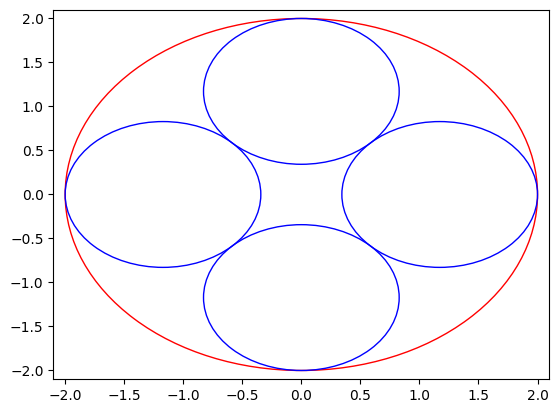

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots() 
ax.set_xlim((-plyCS.ply_radius, plyCS.ply_radius))
ax.set_ylim((-plyCS.ply_radius, plyCS.ply_radius))
circle1 = plt.Circle((0, 0), plyCS.ply_radius-0.1, color='r', fill=False)
ax.add_patch(circle1)

for i in range(plyCS.fiber_count):
    circle = plt.Circle(plyCS.fibers[i], plyCS.fiber_radius, color='b', fill=False)
    ax.add_patch(circle)
    
plt.show()

In [16]:
# fibCS = CrossSection(num_fibers, fiber_twist, 0.5, 0.5, fiber_rad, fiber_origin, plyCS.fiber_radius+0.1)
# fibCS.genFibers(random=True)
# fibCS.extractNormals(res)
# fibCS.extractTangents(res)
# fibCS.extractAO(res)

In [17]:
# with open('./tmp/fibCS_random_single.pickle', 'wb') as f:
#     pickle.dump(fibCS, f)

In [18]:
with open('./tmp/fibCS_random.pickle', 'rb') as f:
    fibCS = pickle.load(f)
    
# fibCS.fiber_twist = -1.5

In [19]:
r_vector = np.array(fibCS.fibers)

In [20]:
r_vector = r_vector
r_vector_norm = np.linalg.norm(r_vector, axis=1)
r_vector = r_vector / r_vector_norm.reshape(r_vector_norm.shape[0],1).repeat(2, axis=1)

In [21]:
r_vector.shape

(25, 2)

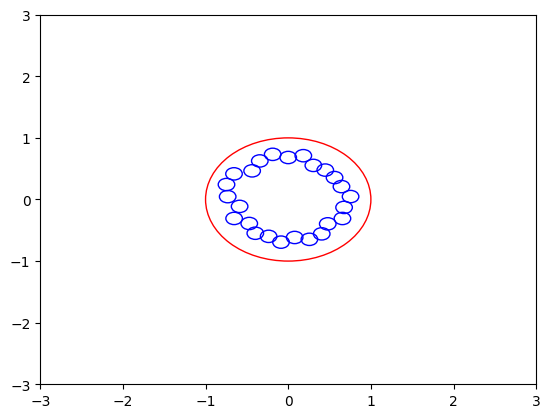

In [22]:
# import matplotlib.pyplot as plt

fig, ax = plt.subplots() 
ax.set_xlim((-3, 3))
ax.set_ylim((-3, 3))
circle1 = plt.Circle((0, 0), fibCS.ply_radius, color='r', fill=False)
ax.add_patch(circle1)

for i in range(fibCS.fiber_count):
    circle = plt.Circle(fibCS.fibers[i], fibCS.fiber_radius, color='b', fill=False)
    ax.add_patch(circle)
    
#     if i % 2 == 0:
#         circle = plt.Circle((fibCS.fibers[i][0]-r_vector[i][0]*fibCS.fiber_radius*2, fibCS.fibers[i][1]-r_vector[i][1]*fibCS.fiber_radius*2), 
#                             fibCS.fiber_radius, color='g', fill=False)
#         ax.add_patch(circle)
        
#     if i % 4 == 0:
#         circle = plt.Circle((fibCS.fibers[i][0]-r_vector[i][0]*fibCS.fiber_radius*4, fibCS.fibers[i][1]-r_vector[i][1]*fibCS.fiber_radius*4), 
#                             fibCS.fiber_radius, color='y', fill=False)
#         ax.add_patch(circle)
    
#     if i % 32 == 0:
#         circle = plt.Circle((fibCS.fibers[i][0]-r_vector[i][0]*fibCS.fiber_radius*6, fibCS.fibers[i][1]-r_vector[i][1]*fibCS.fiber_radius*6), 
#                             fibCS.fiber_radius, color='c', fill=False)
#         ax.add_patch(circle)
        
    # if i % 4 == 0:
    #     circle = plt.Circle((fibCS.fibers[i][0]-r_vector[i][0]*fibCS.fiber_radius*8, fibCS.fibers[i][1]-r_vector[i][1]*fibCS.fiber_radius*8), 
    #                         fibCS.fiber_radius, color='k', fill=False)
    #     ax.add_patch(circle)
    
    # if i % 8 == 0:
    #     circle = plt.Circle((fibCS.fibers[i][0]-r_vector[i][0]*fibCS.fiber_radius*10, fibCS.fibers[i][1]-r_vector[i][1]*fibCS.fiber_radius*10), 
    #                         fibCS.fiber_radius, color='m', fill=False)
    #     ax.add_patch(circle)
    
    
plt.show()

In [23]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots() 
# ax.set_xlim((-3, 3))
# ax.set_ylim((-3, 3))
# circle1 = plt.Circle((0, 0), fibCS.ply_radius, color='r', fill=False)
# ax.add_patch(circle1)

# for i in range(fibCS.fiber_count):
#     circle = plt.Circle(fibCS.fibers[i], fibCS.fiber_radius, color='b', fill=False)
#     ax.add_patch(circle)
    
#     if i % 2 == 0:
#         circle = plt.Circle((fibCS.fibers[i][0]-r_vector[i][0]*fibCS.fiber_radius*2, fibCS.fibers[i][1]-r_vector[i][1]*fibCS.fiber_radius*2), 
#                             fibCS.fiber_radius, color='g', fill=False)
#         ax.add_patch(circle)
        
#     if i % 4 == 0:
#         circle = plt.Circle((fibCS.fibers[i][0]-r_vector[i][0]*fibCS.fiber_radius*4, fibCS.fibers[i][1]-r_vector[i][1]*fibCS.fiber_radius*4), 
#                             fibCS.fiber_radius, color='y', fill=False)
#         ax.add_patch(circle)
    
#     if i % 5 == 0:
#         circle = plt.Circle((fibCS.fibers[i][0]-r_vector[i][0]*fibCS.fiber_radius*6, fibCS.fibers[i][1]-r_vector[i][1]*fibCS.fiber_radius*6), 
#                             fibCS.fiber_radius, color='c', fill=False)
#         ax.add_patch(circle)
        
#     # if i % 4 == 0:
#     #     circle = plt.Circle((fibCS.fibers[i][0]-r_vector[i][0]*fibCS.fiber_radius*8, fibCS.fibers[i][1]-r_vector[i][1]*fibCS.fiber_radius*8), 
#     #                         fibCS.fiber_radius, color='k', fill=False)
#     #     ax.add_patch(circle)
    
#     # if i % 8 == 0:
#     #     circle = plt.Circle((fibCS.fibers[i][0]-r_vector[i][0]*fibCS.fiber_radius*10, fibCS.fibers[i][1]-r_vector[i][1]*fibCS.fiber_radius*10), 
#     #                         fibCS.fiber_radius, color='m', fill=False)
#     #     ax.add_patch(circle)
    
    
# plt.show()

### Diffuse X

In [24]:
class DiffuseX(mi.BSDF):
    def __init__(self, props):
        mi.BSDF.__init__(self, props)

        # Read 'reflectance' properties from `props`
        self.diff_color = props['diff_x']
        
        self.eta = 1.5
        
        # For sub-surface assumption
        self.diff_to_reduced_albedo = [0.000100004, 0.469488, 0.690852, 0.815799, 0.889138, 0.93232,
                                       0.958012, 0.973687, 0.983534, 0.989866, 0.993985, 0.996656,
                                       0.998344, 0.999345, 0.999853, 0.9999,   1.0]
        
        alpha = [0,0,0]
        for i in range(3):
            f = self.diff_color[i] * 15.99
            j = int(f) & 15
            w = f - j
            alpha[i] = self.diff_to_reduced_albedo[j] * ( 1.0 - w ) + self.diff_to_reduced_albedo[j+1] * w
        
        self.alpha = mi.load_string('''<spectrum version='3.0.0' type='srgb' name="reflectance">
                                <rgb name="color" value="{}, {}, {}"/>
                             </spectrum>'''.format(alpha[0], alpha[1], alpha[2]))
        
        self.diff_color = mi.Color3f(props['diff_y'])
        self.diff_color_orig = mi.load_string('''<spectrum version='3.0.0' type='srgb' name="reflectance">
                                <rgb name="color" value="{}, {}, {}"/>
                             </spectrum>'''.format(props['diff_y'][0],props['diff_y'][1],props['diff_y'][2]))
        
        # Set the BSDF flags
        reflection_flags   = mi.BSDFFlags.DiffuseReflection | mi.BSDFFlags.FrontSide | mi.BSDFFlags.BackSide | mi.BSDFFlags.Smooth
        transmission_flags   = mi.BSDFFlags.DiffuseTransmission | mi.BSDFFlags.FrontSide | mi.BSDFFlags.BackSide | mi.BSDFFlags.Smooth
        
        self.m_components  = [reflection_flags, transmission_flags]
        self.m_flags = reflection_flags | transmission_flags
    
    def sample(self, ctx, si, sample1, sample2, active):
        cos_theta_i = mi.Frame3f.cos_theta(si.wi)
        bs = mi.BSDFSample3f()

        active &= cos_theta_i > 0

        bs.wo = mi.warp.square_to_cosine_hemisphere(sample2)
        bs.pdf = mi.warp.square_to_cosine_hemisphere_pdf(bs.wo)

        bs.sampled_type = mi.BSDFFlags.DiffuseReflection
        bs.sampled_component = 0

        value = self.diff_color

        return bs, value
        
    def eval_pdf(self, ctx, si, wo, active):
        mi.set_variant(variant)
        
        thresh = 1.
               
        cos_theta_i = mi.Frame3f.cos_theta(si.wi)
        cos_theta_o = mi.Frame3f.cos_theta(wo)
        
        reflect = cos_theta_i * cos_theta_o > 0
        
        eta = dr.select(cos_theta_i > 0, self.eta, 1 / self.eta)
        inv_eta = dr.select(cos_theta_i > 0, 1 / self.eta, self.eta)
        
        alpha = self.alpha

        # Diffuse X
        Fdr = -1.440 / ( self.eta * self.eta ) + 0.710 / self.eta + 0.668 + 0.0636 * self.eta
        Fdr = dr.clip(Fdr, 0, 1)
        A = ( 1 + Fdr ) / ( 1 - Fdr )
        
        t1 = alpha.eval(si, active) / (4 * dr.pi * (cos_theta_o + cos_theta_i))
        str_ = dr.sqrt(3 * (1 - alpha.eval(si, active)))
        t2 = (alpha.eval(si, active) * 0.5) * (1 + dr.exp(-4 / 3 * A * str_)) * dr.exp(-str_) * (dr.inv_pi)
        
        value_xrb = mi.Color3f(t1)
        value_xrb_diff = mi.Color3f(t2)
        
        weight = (cos_theta_o + cos_theta_i) * dr.sign(cos_theta_o + cos_theta_i)
        weight = (weight - dr.min(weight)) / (dr.max(weight) - dr.min(weight))

        value_bx = dr.lerp(mi.Color3f(value_xrb_diff), mi.Color3f(value_xrb), weight)
        # value_bx = (mi.Color3f(value_xrb_diff) * (1 - thresh) + thresh * mi.Color3f(value_xrb))
                    
        # Diffuse Y
        value_by = mi.Color3f(self.diff_color_orig.eval(si, active) * 1 / dr.pi * dr.abs(cos_theta_o))        
        
        value = dr.select(reflect, value_bx, value_by)
        
        pdf = mi.warp.square_to_cosine_hemisphere_pdf(wo)

        return dr.abs(value), pdf

    def traverse(self, callback):
        callback.put_parameter('reflectance', self.reflectance, mi.ParamFlags.Differentiable)

    def parameters_changed(self, keys):
        print("🏝️ there is nothing to do here 🏝️")

    def to_string(self):
        return ('Diffuse[\n'
                '    diff_color=%s,\n'
                ']' % (self.diff_color))

In [25]:
mi.register_bsdf("diffuseX", lambda props: DiffuseX(props))

### Initialize All BSDFs

In [26]:
specX = mi.load_dict({
    'type' : 'roughdielectric',
    'alpha_u': specx_alphau,
    'alpha_v': specx_alphav,
    'distribution': 'ggx',
    'int_ior' : m_eta,        
    'ext_ior' : 1.,
    'specular_reflectance': {
        'type': 'rgb',
        'value': specx_color,
    },
    'specular_transmittance': {
        'type': 'rgb',
        'value': specx_color,
    },
})

In [27]:
specY = mi.load_dict({
    'type' : 'roughdielectric',
    'alpha_u': specy_alphau,
    'alpha_v': specy_alphav,
    'distribution': 'ggx',
    'int_ior' : 1.5,        
    'ext_ior' : 1.,
    'specular_reflectance': {
        'type': 'rgb',
        'value': [0.0, 0.0, 0.0],
    },
    'specular_transmittance': {
        'type': 'rgb',
        'value': specy_color,
    },
})

In [28]:
diffx = mi.load_dict({
    'type': 'diffuseX',
    'diff_x': diff_color_x,
    'diff_y': diff_color_y,
})

diffx

Diffuse[
    diff_color=[[1.0, 0.0, 0.0]],
]

In [29]:
diff_orig = mi.load_dict({
    'type': 'diffuse',
    'reflectance': {
        'type': 'rgb',
        'value': diff_color_x
    }
})

diff_orig

SmoothDiffuse[
  reflectance = SRGBReflectanceSpectrum[
    value = [[1, 0, 0]]
  ]
]

### Ply Intersection Code

In [30]:
def ray_test_ply(si, rmf_normal, plyCS, rays):
    mask = False
    
    final_t = dr.inf
    
    '''Use RMF To Create Frame'''    
    yarn_point = (si.p - rad * si.n)
    yarn_frame = mi.Frame3f(dr.normalize(dr.cross(si.sh_frame.t,rmf_normal)*-1), rmf_normal, si.sh_frame.t)
    
    '''Projected Ray In 2D Cross-Section'''
    rays_projected_d = rays.d - dr.dot(rays.d, si.sh_frame.t) * si.sh_frame.t
    rays_projected_d = dr.normalize(rays_projected_d)
    rays_projected_o = si.p

    rays_projected = mi.Ray3f(rays_projected_o, rays_projected_d)
    
    length_yarn = si.uv.y
    
    rotation = mi.Transform4f.rotate(mi.Vector3f(0,0,1), 
                                (si.uv.y * -plyCS.fiber_twist) * 180 / dr.pi)
            
    for i in range(plyCS.fiber_count):
        '''Rotate To Get Center Location On Circular Cross-Section'''
        center = mi.Point3f(plyCS.fibers[i][0], plyCS.fibers[i][1], 0)
        
        new_center = rotation.transform_affine(center)
        
        frame_correction = mi.Transform4f.translate(yarn_point) @ mi.Transform4f.to_frame(yarn_frame)
        new_center = frame_correction.transform_affine(new_center)
                
        t = rayPlyIntersection2D_emmiter(new_center, rays_projected)
        final_t = dr.select(dr.abs(t) < dr.abs(final_t), t, final_t)

#         dist_ray = (new_center-rays_projected_o) - \
#                         dr.dot((new_center-rays_projected_o), rays_projected_d) * rays_projected_d
        
#         mask = dr.or_(dr.norm(dist_ray) <= plyCS.fiber_radius, mask)
        
    mask = ~dr.isinf(final_t)
    
    return mask

In [31]:
def rayPlyIntersection2D_emmiter(center, rays):
    a = dr.norm(rays.d)**2
    b = 2 * dr.dot(rays.o - center, rays.d)
    c = dr.norm(rays.o - center)**2 - plyCS.fiber_radius**2

    t1 = dr.select(b**2 - 4*a*c >=0, (-b + dr.sqrt(b**2 - 4*a*c)) / (2 * a), dr.inf)
    t2 = dr.select(b**2 - 4*a*c >=0, (-b - dr.sqrt(b**2 - 4*a*c)) / (2 * a), dr.inf)
    # t1 = dr.select(t1 > 0, t1, dr.inf); t2 = dr.select(t2 > 0, t2, dr.inf)
    
    t = dr.select(dr.abs(t1) < dr.abs(t2), t1, t2)
    
    return t

In [32]:
def rayPlyIntersection2D(center, rays):
    a = dr.norm(rays.d)**2
    b = 2 * dr.dot(rays.o - center, rays.d)
    c = dr.norm(rays.o - center)**2 - plyCS.fiber_radius**2

    t1 = dr.select(b**2 - 4*a*c >=0, (-b + dr.sqrt(b**2 - 4*a*c)) / (2 * a), dr.inf)
    t2 = dr.select(b**2 - 4*a*c >=0, (-b - dr.sqrt(b**2 - 4*a*c)) / (2 * a), dr.inf)
    # t1 = dr.select(t1 > 0, t1, dr.inf); t2 = dr.select(t2 > 0, t2, dr.inf)
    
    t = dr.select(dr.abs(t1) < dr.abs(t2), t1, t2)
    
    return t

In [33]:
def rayPlyIntersection3D(si, rmf_normal, plyCS, rays):
    mask = False
    not_mask = False
    
    final_t = dr.inf
    ply_normal = mi.Vector3f(0)
    ply_tangent = mi.Vector3f(0)
    ply_hit_point = mi.Point3f(0)
    ply_center = mi.Point3f(0)
    ply_num = 0
    ply_count = mi.Float(0)
    
    '''Use RMF To Create Frame'''    
    yarn_point = (si.p - rad * si.n)
    yarn_frame = mi.Frame3f(dr.normalize(dr.cross(si.sh_frame.t,rmf_normal)*-1), rmf_normal, si.sh_frame.t)
    # yarn_frame = mi.Frame3f(si.sh_frame.t)
    
    '''Projected Ray In 2D Cross-Section'''
    rays_projected_d = rays.d - dr.dot(rays.d, si.sh_frame.t) * si.sh_frame.t
    rays_projected_d = dr.normalize(rays_projected_d)
    rays_projected_o = si.p

    rays_projected = mi.Ray3f(rays_projected_o, rays_projected_d)
    
    length_yarn = si.uv.y
    
    rotation = mi.Transform4f.rotate(mi.Vector3f(0,0,1), 
                                (si.uv.y * -plyCS.fiber_twist) * 180 / dr.pi)
            
    for i in range(plyCS.fiber_count):
        '''Rotate To Get Center Location On Circular Cross-Section'''
        center = mi.Point3f(plyCS.fibers[i][0], plyCS.fibers[i][1], 0)
        
        new_center = rotation.transform_affine(center)
        
        frame_correction = mi.Transform4f.translate(yarn_point) @ mi.Transform4f.to_frame(yarn_frame)
        new_center = frame_correction.transform_affine(new_center)
                
        '''Intersect Projected Rays With Plies In 2D'''
        t = rayPlyIntersection2D(new_center, rays_projected)
        
        '''Get Ply Tangent Using Helix Derivative'''
        x = mi.Float(dr.cos(length_yarn * mi.Float(plyCS.fiber_twist) + dr.two_pi/plyCS.fiber_count*i)) *\
                        mi.Float(plyCS.fiber_origin) * mi.Float(plyCS.fiber_twist)
        y = mi.Float(-dr.sin(length_yarn * mi.Float(plyCS.fiber_twist) + dr.two_pi/plyCS.fiber_count*i)) *\
                        mi.Float(plyCS.fiber_origin) * mi.Float(plyCS.fiber_twist)

        v = mi.Vector3f(0); v.x = x; v.y = y; v.z = 1
        hel_tangent = dr.normalize(v)

        tangent_correction = mi.Transform4f.to_frame(yarn_frame)
        hel_tangent = dr.normalize(tangent_correction.transform_affine(hel_tangent))
        
        '''Update Hit-Point Normals And Tangents'''
        t_mask = dr.abs(t) < dr.abs(final_t)
        ply_hit_point = dr.select(t_mask, rays_projected_o + t * rays_projected_d, ply_hit_point)
        ply_normal = dr.select(t_mask, dr.normalize(ply_hit_point - new_center), ply_normal)        
        ply_tangent = dr.select(t_mask, hel_tangent, ply_tangent)
        ply_center = dr.select(t_mask, new_center, ply_center)
        ply_num = dr.select(t_mask, i, ply_num)
        final_t = dr.select(dr.abs(t) < dr.abs(final_t), t, final_t)
    
        ply_count += dr.select(dr.isinf(t), 0., 1.)
                              
    '''Remove Component Of Normal Along Tanget'''
    ply_normal = dr.normalize(ply_normal-dr.dot(ply_normal, ply_tangent)*ply_tangent)
    
    '''Ply UV Calculation'''
    ply_reference_normal = dr.normalize(rmf_normal-dr.dot(rmf_normal, ply_tangent)*ply_tangent)
    ply_reference_binormal = dr.normalize(dr.cross(ply_reference_normal, ply_tangent))
    
    ply_uv = dr.atan2(dr.dot(ply_normal, ply_reference_normal), dr.dot(ply_normal, ply_reference_binormal))
    ply_uv += dr.select(ply_uv < 0, dr.two_pi, 0) # + ply_num * np.random.rand()*dr.pi
    
    '''Ply-Hit Mask'''
    mask = ~dr.isinf(final_t)
    
    '''Ply Reference Frame For Fiber Mapping'''
    ply_reference_frame = mi.Frame3f(ply_reference_binormal, ply_reference_normal, ply_tangent)
    
    '''Get Ply Shadow'''
    ply_hit_yarn_normal = dr.normalize(ply_hit_point-yarn_point)
    angle = dr.atan2(dr.dot(ply_hit_yarn_normal, yarn_frame.t), dr.dot(ply_hit_yarn_normal, yarn_frame.s))
    angle += dr.select(angle<0, dr.two_pi, 0)
    
    u = mi.Float(angle)
    u += plyCS.fiber_twist * length_yarn
    u -= dr.trunc(u / dr.two_pi) * dr.two_pi
    u /= dr.two_pi
    u = u * (res-1); u = dr.select(dr.isnan(u), 0, u)
    u = mi.Point1i(u).x
    u = dr.select(u < 0, 1000+u,u)
    
    aoCS = dr.llvm.ad.Float(np.array(plyCS.aoCS))
    ply_shadow = dr.gather(dtype=type(aoCS), source=aoCS, index=u, active=si.is_valid())
    
    del aoCS
        
    return mask, ply_normal, ply_tangent, ply_shadow, ply_reference_frame, ply_uv / dr.two_pi, ply_count

### Fiber Intersection Code

In [34]:
def updateFiberGeometry(si, cs, uv, ply_reference_frame, res=1000, h=mi.Point3f(0), d_factor = 20., num_samples=100):
    h_max_to_u = mi.Float(dr.asin(h.z / cs.ply_radius))
    h_min_to_u = mi.Float(dr.asin(h.y / cs.ply_radius))
    h = (h_max_to_u - h_min_to_u) / num_samples
    # h_to_u = mi.Float(dr.asin(h))
    
    '''Get The T-value = length of curve till that point'''    
    t_hel = si.uv.y # Length using V-value of each cylinder
    t_world = t_hel
    
    ply_uv = mi.Point2f(uv, dr.sqrt((plyCS.fiber_origin * plyCS.fiber_twist)**2 + 1) * (t_world))
    # ply_uv = si.uv
    
    final_fiber_normal = mi.Vector3f(0)
    final_fiber_tangent = mi.Vector3f(0)
    final_fiber_shadow = mi.Float(0)
    weight_sum = mi.Float(0)
    
    u = mi.Point2f(ply_uv).x * dr.two_pi
    u += cs.fiber_twist * ply_uv.y
    u -= dr.trunc(u / dr.two_pi) * dr.two_pi
    u /= dr.two_pi
    u = u * (res-1); u = dr.select(dr.isnan(u), 0, u)
    u = mi.Point1i(u).x
    u = dr.select(u < 0, 1000+u,u)
    
    # fib_center = dr.llvm.ad.Array2f(np.array(cs.visFibersCenter))
    # curr_fiber_center = dr.gather(dtype=type(fib_center), source=fib_center, index=u, active=si.is_valid())
    # del fib_center
    
    fib_hit = dr.llvm.ad.Array2f(np.array(cs.visFibers))
    curr_fiber_hit = dr.gather(dtype=type(fib_hit), source=fib_hit, index=u, active=si.is_valid())
    del fib_hit
    
    for i in range(num_samples):
    # for i in range(0, num_samples, 1):
        u = mi.Point2f(ply_uv).x * dr.two_pi + (i * (h) + h_min_to_u)
        u += cs.fiber_twist * ply_uv.y # + (dr.sqr(h_to_u) - dr.sqr(h_to_u * i / num_samples))
        u -= dr.trunc(u / dr.two_pi) * dr.two_pi
        u /= dr.two_pi
        u = u * (res-1); u = dr.select(dr.isnan(u), 0, u)
        u = mi.Point1i(u).x
        u = dr.select(u < 0, 1000+u,u)

        '''Fiber Normal Rotation Angle based on UV'''
        pertCS = dr.llvm.ad.Float(np.array(cs.pertCS))
        fib_normal_pert_angle = dr.gather(dtype=type(pertCS), source=pertCS, index=u, active=si.is_valid())    

        '''Fiber Tangent Phase based on UV'''
        theta0CS = dr.llvm.ad.Float(np.array(cs.theta0CS))
        theta0 = dr.gather(dtype=type(theta0CS), source=theta0CS, index=u, active=si.is_valid())

        fib_center = dr.llvm.ad.Array2f(np.array(cs.visFibersCenter))
        fiber_origin = dr.gather(dtype=type(fib_center), source=fib_center, index=u, active=si.is_valid())
        fiber_origin = dr.norm(fiber_origin)
        
        # weight = dr.exp(-d_factor * dr.norm(fiber_center-curr_fiber_center))

        fib_hit = dr.llvm.ad.Array2f(np.array(cs.visFibers))
        fiber_hit = dr.gather(dtype=type(fib_hit), source=fib_hit, index=u, active=si.is_valid())
        
        # fiber_hit_3d = mi.Point3f(fiber_hit.x, fiber_hit.y, 0)
        # frame_correction = mi.Transform4f.translate(si.p-(cs.ply_radius-0.1)*si.n) @ mi.Transform4f.to_frame(ply_reference_frame)
        # new_fib_hit = frame_correction.transform_affine(fiber_hit_3d)
        
        weight = dr.exp(-d_factor * dr.norm(fiber_hit-curr_fiber_hit))

        '''Ambient Occlusion based on UV'''
        aoCS = dr.llvm.ad.Float(np.array(cs.aoCS))
        fib_shadow_x = dr.gather(dtype=type(aoCS), source=aoCS, index=u, active=si.is_valid())

        '''Get the Fiber Tangent and transform to match the axis of the ply'''
        # start = time.time()
        x = mi.Float(dr.cos(ply_uv.y * mi.Float(cs.fiber_twist) + theta0)) * fiber_origin * mi.Float(cs.fiber_twist) #* 2.3
        y = mi.Float(-dr.sin(ply_uv.y * mi.Float(cs.fiber_twist) + theta0)) * fiber_origin * mi.Float(cs.fiber_twist) #* 2.3
        # print('x',time.time()-start)

        # start = time.time()
        v = mi.Vector3f(0); v.x = x; v.y = y; v.z = 1
        hel_tangent = dr.normalize(v)
        # print('t',time.time()-start)

        duv = si.sh_frame.t
        length = dr.norm(duv)

        to_world = mi.Transform4f.to_frame(ply_reference_frame)
        hel_tangent = dr.normalize(to_world.transform_affine(hel_tangent))
        # hel_tangent = si.sh_frame.t

        '''Update Fiber Normal by removing component of Fiber Tangent Along It'''
        fib_normal = mi.Vector3f(si.n)
        fib_normal = dr.normalize(fib_normal - dr.dot(fib_normal, hel_tangent) * hel_tangent)

        axis = dr.normalize(hel_tangent)
        zn = dr.rotate(mi.Quaternion4f, axis, fib_normal_pert_angle); zn = fixed_quat_to_matrix(zn)
        fib_normal = dr.normalize(zn @ fib_normal)
        
        final_fiber_normal += weight * fib_normal
        final_fiber_tangent += weight * hel_tangent
        # final_fiber_shadow += weight * fib_shadow_x
        final_fiber_shadow += fib_shadow_x
        weight_sum += weight

        del aoCS
        del theta0CS
        del fib_hit
        del fib_center
        del fib_normal_pert_angle
            
    # return dr.normalize((final_fiber_normal) / weight_sum), dr.normalize((final_fiber_tangent) / weight_sum), final_fiber_shadow / weight_sum
    return dr.normalize((final_fiber_normal) / weight_sum), dr.normalize((final_fiber_tangent) / weight_sum), final_fiber_shadow / num_samples

In [35]:
def mapPlyFiberGeometry(si, ply_uv, ply_reference_frame, bsdf_mask, fibCS, rays, h=mi.Point3f(0), num_samples=10):
    fiber_normal, fiber_tangent, fiber_shadow = updateFiberGeometry(si, fibCS, ply_uv, ply_reference_frame, 
                                                                    h=h, num_samples=num_samples)

    si.n = dr.select(bsdf_mask, dr.normalize(fiber_normal), si.n)
    si.sh_frame.n = si.n
    si.sh_frame.t = dr.select(bsdf_mask, dr.normalize(fiber_tangent), si.sh_frame.t)
    si.sh_frame.s = dr.select(bsdf_mask, dr.normalize(dr.cross(si.sh_frame.n, si.sh_frame.t)) * -1, si.sh_frame.s)
    
    return si, fiber_shadow

### Scene Intersection 

In [36]:
def intersectWithScene(scene, rays, active, plyCS, scale=scale_V):
    si = scene.ray_intersect(rays, active)
    valid_ray = si.is_valid() & active
    
    rmf_normal = mi.Vector3f(si.n) # For now we store the RMF normal in si.n
    
    yarn_number = si.dn_du.x
    
    per_yarn_length = dr.llvm.ad.Float(np.array(length_sum))
    scale_f = dr.gather(dtype=type(per_yarn_length), source=per_yarn_length, index=mi.Int(yarn_number), active=si.is_valid())
    
    colors = mi.Color3f(0)
    colors = dr.select(dr.eq(mi.Int(yarn_number) % 3, 0), mi.Color3f((0.015, 0.00, 0.24)), colors)
    colors = dr.select(dr.eq(mi.Int(yarn_number) % 3, 1), mi.Color3f((0.015, 0.24, 0.00)), colors)
    colors = dr.select(dr.eq(mi.Int(yarn_number) % 3, 2), mi.Color3f((0.24, 0.00, 0.015)), colors)
    # colors = dr.select(dr.eq(mi.Int(yarn_number) % 4, 3), mi.Color3f((0.01, 0.0, 0.05)), colors)

    uv = mi.Point2f(si.uv)
    si.uv.x = uv.y 
    si.uv.y = uv.x * scale_f # V in [0,1] so scale it to make the ply twist more visible
                
    frame = mi.Frame3f(si.sh_frame)
    si.sh_frame.t = frame.s
    si.sh_frame.s = frame.t
    si.n = si.sh_frame.n
    
    si.dn_du = mi.Vector3f(0)
    
    '''Generate No-Hit Mask And Get Ply Geometry'''
    # start = time.time()
    hit, ply_normal, ply_tangent, ply_shadow, ply_reference_frame, ply_uv, ply_count = rayPlyIntersection3D(si, rmf_normal, 
                                                                                                 plyCS, rays)
    # print('Time for ply mapping', time.time()-start)
    
    bsdf_mask = dr.and_(valid_ray, hit)
    
    si.n = dr.select(bsdf_mask, dr.normalize(ply_normal), si.n)
    si.sh_frame.n = si.n
    si.sh_frame.t = dr.select(bsdf_mask, dr.normalize(ply_tangent), si.sh_frame.t)
    si.sh_frame.s = dr.select(bsdf_mask, dr.normalize(dr.cross(si.sh_frame.n, si.sh_frame.t)) * -1, si.sh_frame.s)
        
    return si, bsdf_mask, ply_normal, ply_tangent, ply_shadow, ply_reference_frame, ply_uv, ply_count, scale_f, colors

In [37]:
def ray_test(scene2, rays2, active2, emitter_point, scale2, count=0):
    si2 = scene2.ray_intersect(rays2, active2)
    
    rmf_normal2 = mi.Vector3f(si2.n) # For now we store the RMF normal in si.n
    
    yarn_number = si2.dn_du.x
    
    per_yarn_length = dr.llvm.ad.Float(np.array(length_sum))
    scale_f = dr.gather(dtype=type(per_yarn_length), source=per_yarn_length, index=mi.Int(yarn_number), active=si2.is_valid())

    uv = mi.Point2f(si2.uv)
    si2.uv.x = uv.y 
    si2.uv.y = uv.x * scale_f # V in [0,1] so scale it to make the ply twist more visible
                
    frame = mi.Frame3f(si2.sh_frame)
    si2.sh_frame.t = frame.s
    si2.sh_frame.s = frame.t
    si2.n = si2.sh_frame.n
    
    si2.dn_du = mi.Vector3f(0)
    
    mask = ray_test_ply(si2, rmf_normal2, plyCS, rays2)
    
    if count < 0:
        rays_next = si2.spawn_ray_to(emitter_point)
        
        mask = dr.or_(mask, ray_test(scene2, rays_next, ~mask, emitter_point, scale2, count=count+1))
    
    return mask
    # return si2.is_valid()
    # return dr.and_(si.is_valid(), mask)

### Custom Integrator

In [38]:
from common import *
from typing import *

In [39]:
def mis_weight(pdf_a, pdf_b):
    a2 = dr.sqr(pdf_a)
    b2 = dr.sqr(pdf_b)
    w = a2 / (a2 + b2)
    return dr.detach(dr.select(dr.isfinite(w), w, 0))

def integrator_sample(scene, sampler, rays, medium, active):
    mi.set_variant(variant)
    rays.d = dr.normalize(rays.d)
    rays.d_x = dr.normalize(rays.d_x)
    rays.d_y = dr.normalize(rays.d_y)
        
    ctx = mi.BSDFContext()
    result = mi.Float(0.)
    depth = 0
    prev_si = mi.SurfaceInteraction3f()
    prev_mask = mi.Mask(False)
    throughput = mi.Spectrum(1.)
    prev_attn_fac = mi.Float(1.)
    prev_attn_d_fac = mi.Float(1.)
    F_prev = 1.
    
    while depth < max_depth:
        '''Ray Scene Intersection'''
        si, mask, ply_normal, ply_tangent, ply_shadow, ply_reference_frame, \
                    ply_uv, ply_count, scale_f, colors = intersectWithScene(scene, rays, active, plyCS, scale=scale_V)
        ply_shadow = ply_shadow * (1 - ply_shadow_thr) + ply_shadow_thr
        ply_shadow = dr.select(dr.eq(plyCS.fiber_count, 1), 1., ply_shadow)
                
        active = si.is_valid()
        
        '''Calculate Azimuthal Offset'''
        if depth == 0:
            h_min = -dr.select(active, dr.norm((rays.o + si.t * rays.d) - (rays.o_x + si.t * rays.d_x)), 0)
            h_max = dr.select(active, dr.norm((rays.o + si.t * rays.d) - (rays.o_y + si.t * rays.d_y)), 0)
            
            h_range = np.array(dr.abs(dr.max(h_max) - dr.min(h_min)))[0]
            # h_range = dr.select(active, 
            
            print(dr.min(h_min))
            print(dr.max(h_max))
            print(h_range)
                          
        # print(dr.min(dr.select(active, h_min, dr.inf)), dr.min(dr.select(active, h_max, dr.inf)))
        # print(dr.max(dr.select(active, h_min, 0)), dr.max(dr.select(active, h_max, 0)))
        
        if depth == 0:
            prev_si = mi.SurfaceInteraction3f(si)
        
        if depth % 2 == 0:
            bsdf_mask = mi.Mask(mask)
            
        '''Geometry Mapping For Ply And Fiber'''
        # start = time.time()
        
        # M-Res
        si, fiber_shadow = mapPlyFiberGeometry(si, ply_uv, ply_reference_frame, bsdf_mask, fibCS, 
                                               rays, h=mi.Point3f((dr.abs(h_max-h_min), h_min, h_max)), num_samples=25)
        
        # Far- Field
        # si, fiber_shadow = mapPlyFiberGeometry(si, ply_uv, ply_reference_frame, bsdf_mask, fibCS, 
        #                                        rays, h=mi.Point3f((0, -fibCS.ply_radius+0.1, fibCS.ply_radius-0.1)), num_samples=25)
        # si, fiber_shadow = mapPlyFiberGeometry(si, ply_uv, ply_reference_frame, bsdf_mask, fibCS, 
        #                                        rays, h=mi.Point3f((0, -2, 2)), num_samples=25)
        # h_range = (2) * 2
        
        # Near-Field
        # si, fiber_shadow = mapPlyFiberGeometry(si, ply_uv, ply_reference_frame, bsdf_mask, fibCS, rays, h=mi.Point3f(0), num_samples=1)
        # h_range = 0
        
        fiber_shadow = fiber_shadow * (1 - shadow_thr) + shadow_thr
        # print('Time for fiber mapping', time.time()-start)

        si.wi = si.to_local(-rays.d)
        
#         orig_si = mi.SurfaceInteraction3f(si)

        '''Emitter Sampling'''
        emitter_vis = si.emitter(scene, active)
        if depth == 0:
            emitter_vis = si.emitter(scene, True)
            result += emitter_vis.eval(si, True)
        
        if backlight:
            # occluded = True
            sample_emitter = active
        else:
            # occluded = False
            # sample_emitter = dr.and_(active, ~prev_mask)
            sample_emitter = active
        
        sample_emitter = dr.and_(active, bsdf_mask)
        # if depth == 0:
            # occlusion = True
        # else:
            # occlusion = False
        occlusion = True
        ds, emitter_val = scene.sample_emitter_direction(si, sampler.next_2d(sample_emitter), False, sample_emitter)
        
        # emitter_ray = mi.Ray3f(si.p+1.0e-3*(dr.normalize(ds.p-si.p)), (dr.normalize(ds.p-si.p)))
        emitter_ray = si.spawn_ray_to(ds.p)
        occluded = ray_test(scene, emitter_ray, si.is_valid(), ds.p, scale2=scale_V)
        ds.pdf = dr.select(occluded, 0, ds.pdf)
        emitter_val = dr.select(occluded, 0, emitter_val)
        
        emitter_val = dr.select(dr.neq(ds.pdf, 0), emitter_val / ds.pdf, 0)
        # emitter_val = dr.select(dr.neq(ds.pdf, 0), emitter_val, 0)
        active_e = sample_emitter & dr.neq(ds.pdf, 0.0)
        
        '''Eval BSDF'''
        # si = mi.SurfaceInteraction3f(orig_si)

        si.wi = si.to_local(-rays.d)
        wo = si.to_local(ds.d) 
        
        # Calculate B(wi, wo)
        cos_theta_i = mi.Frame3f.cos_theta(si.wi)
        cos_theta_o = mi.Frame3f.cos_theta(wo)
        
        reflect = mi.Mask((cos_theta_i * cos_theta_o) > 0)
                
        F_curr = mi.fresnel(cos_theta_i, m_eta)[0]
        
        Fx = dr.select(reflect, F_curr, F_prev)
        Fy = dr.select(reflect, F_prev, F_curr)
        
        # Get r
        r = dr.select(reflect, m_r, (1 - m_r))
        
        # Specular Component
        attn_fac = dr.select(depth % 2 == 0, 1, dr.power(dr.abs(dr.exp(-sigma * dr.norm(si.p-prev_si.p))), ply_count))
        # attn_fac = dr.select(depth == 0, 1, dr.power(dr.abs(dr.exp(-sigma * dr.norm(si.p-prev_si.p))), ply_count))
        attn_fac = dr.select(dr.isnan(attn_fac), 1, attn_fac)

        if depth % 2 == 0:
            # X-Component At First Hit
            cos_theta_i = mi.Frame3f.cos_theta(si.wi)

            F_curr = mi.fresnel(cos_theta_i, m_eta)[0]
            
            specX = mi.load_dict({
                'type' : 'roughdielectric',
                'alpha_u': specx_alphau + h_range/(10),
                'alpha_v': specx_alphav + h_range/(10),
                'distribution': 'ggx',
                'int_ior' : m_eta,        
                'ext_ior' : 1.,
                'specular_reflectance': {
                    'type': 'rgb',
                    'value': specx_color,
                },
                'specular_transmittance': {
                    'type': 'rgb',
                    'value': specx_color,
                },
            })
            
            bsdf_val, bsdf_pdf = specX.eval_pdf(ctx, si, wo, bsdf_mask)
            bsdf_val = dr.select(dr.isnan(bsdf_val), 0, bsdf_val)
        else:
            # Y-Component At Second Hit
            cos_theta_i = mi.Frame3f.cos_theta(si.wi)

            F_curr = mi.fresnel(cos_theta_i, m_eta)[0]
            
            bsdf_val, bsdf_pdf = specY.eval_pdf(ctx, si, wo, bsdf_mask)
            bsdf_val = dr.select(dr.isnan(bsdf_val), 0, bsdf_val) # * attn_fac
            
        mis = dr.select(ds.delta, 1.0, mis_weight(ds.pdf, bsdf_pdf))
        
        result += dr.select(dr.and_(sample_emitter, bsdf_mask), 
                            prev_attn_fac * attn_fac * r * bsdf_val * emitter_val * mis, # * fiber_shadow 
                            mi.Color3f(0.0))
        # result = dr.select(bsdf_mask, mi.Color3f(ply_count), mi.Color3f(0.0))

        
        # Body Component
        attn_fac_d = dr.select(depth % 2 == 0, 1, dr.power(dr.abs(dr.exp(-sigma_d * dr.norm(si.p-prev_si.p))), ply_count))
        # attn_fac_d = dr.select(depth == 0, 1, dr.power(dr.abs(dr.exp(-sigma_d * dr.norm(si.p-prev_si.p))), ply_count))
        attn_fac_d = dr.select(dr.isnan(attn_fac_d), 1, attn_fac_d)
        
        bsdf_val, _ = diffx.eval_pdf(ctx, si, wo, bsdf_mask)
        _, bsdf_pdf = diff_orig.eval_pdf(ctx, si, wo, bsdf_mask)
        bsdf_val = dr.select(dr.isnan(bsdf_val), 0, bsdf_val)
                
        mis = dr.select(ds.delta, 1.0, mis_weight(ds.pdf, bsdf_pdf))
        
        # result += dr.select(dr.and_(sample_emitter, bsdf_mask), 
        #                     prev_attn_d_fac * attn_fac_d * bsdf_val * r * ply_shadow * emitter_val * mis * fiber_shadow, #  , 
        #                     # mi.Color3f(dr.select(occluded, 0, 1)), 
        #                     mi.Color3f(0.0))
        
        result += dr.select(dr.and_(sample_emitter, bsdf_mask), 
                            prev_attn_d_fac * attn_fac_d * bsdf_val.x * colors * r * ply_shadow * emitter_val * mis * fiber_shadow, #  , 
                            # mi.Color3f(dr.select(occluded, 0, 1)), 
                            mi.Color3f(0.0))
        
        
        # result = dr.select(dr.and_(si.is_valid(), ~occluded), mi.Color3f(0.), mi.Color3f(1.))
        
        # result = dr.select(si.is_valid(), mi.Color3f(0), mi.Color3f(1))
        
        # result = dr.select(dr.and_(sample_emitter, bsdf_mask), 
        #                     emitter_val, 
        #                     mi.Color3f(0.0)) 
        
        '''Sample Ray Direction'''
        if depth % 2 == 0:            
            sx_sample, sx_weight = specX.sample(ctx, si,
                                                1.1,
                                                sampler.next_2d(),
                                                bsdf_mask)
            bsdf_sample = sx_sample
            bsdf_weight = sx_weight
        else:            
            sx_sample, sx_weight = specY.sample(ctx, si,
                                                1.1,
                                                sampler.next_2d(),
                                                bsdf_mask)
            bsdf_sample = sx_sample
            bsdf_weight = sx_weight
        
        # bsdf_weight = dr.select(dr.eq(ply_count, 2), dr.sqr(bsdf_weight), bsdf_weight)
        # bsdf_weight = dr.select(ply_count > 1, dr.sqr(dr.sqr(bsdf_weight)), bsdf_weight)

        spawn_dir = dr.select(depth % 2 == 0, -si.n, si.n)
        origin = si.p + spawn_dir * 1.0e-3
        direction = dr.select(bsdf_mask, si.to_world(bsdf_sample.wo), 
                                                   rays.d)
        # direction = dr.mulsign(dr.abs(direction), rays.d)
        rays = mi.Ray3f(origin, dr.normalize(direction))
        
        prev_si = mi.SurfaceInteraction3f(si)
        prev_mask = dr.select(depth % 2 == 0, mi.Mask(bsdf_mask), prev_mask)
        prev_attn_fac *= dr.select(bsdf_mask, attn_fac, 1.)
        prev_attn_d_fac *= dr.select(bsdf_mask, attn_fac_d, 1.)
        throughput *= dr.select(bsdf_mask, bsdf_weight, mi.Spectrum(1))
        F_prev = mi.Float(F_curr)
        active = si.is_valid()
        depth += 1
               
    return result, bsdf_mask, dr.select(bsdf_mask, si.t, 0.0)

### Custom Integrator Ray Differential

In [40]:
class MyDirectIntegrator(mi.SamplingIntegrator):
    def __init__(self, props):
        mi.SamplingIntegrator.__init__(self, props)

    def sample(self, scene, sampler, ray, medium, active):
        mi.set_variant(variant)

        result, is_valid, depth = integrator_sample(scene, sampler, ray, medium, active)
        return result, is_valid, [depth]
    
    def render_forward(self: mi.SamplingIntegrator,
                       scene: mi.Scene,
                       params: Any,
                       sensor: Union[int, mi.Sensor] = 0,
                       seed: int = 0,
                       spp: int = 0) -> mi.TensorXf:
                
        if isinstance(sensor, int):
            sensor = scene.sensors()[sensor]

        film = sensor.film()
        aovs = self.aovs()

        # Disable derivatives in all of the following
        with dr.suspend_grad():
            # Prepare the film and sample generator for rendering
            sampler, spp = self.prepare(sensor, seed, spp, aovs)

            reparam = None
            
            # Generate a set of rays starting at the sensor, keep track of
            # derivatives wrt. sample positions ('pos') if there are any
            ray, weight, pos, det = self.sample_rays(scene, sensor,
                                                     sampler, reparam)

            with dr.resume_grad():
                L, valid, _ = self.sample(
                    scene=scene,
                    sampler=sampler,
                    ray=ray,
                    medium=None,
                    active=mi.Bool(True)
                )

                block = film.create_block()
                # Only use the coalescing feature when rendering enough samples
                block.set_coalesce(block.coalesce() and spp >= 4)

                # Deposit samples with gradient tracking for 'pos'.
                # After reparameterizing the camera ray, we need to evaluate
                #   Σ (fi Li det)
                #  ---------------
                #   Σ (fi det)
                ADIntegrator._splat_to_block(
                    block, film, pos,
                    value=L * weight * det,
                    weight=det,
                    alpha=dr.select(valid, mi.Float(1), mi.Float(0)),
                    wavelengths=ray.wavelengths
                )

                # Perform the weight division and return an image tensor
                film.put_block(block)
                result_img = film.develop()

                dr.forward_to(result_img)

        return dr.grad(result_img)
    
    def sample_rays(
        self,
        scene: mi.Scene,
        sensor: mi.Sensor,
        sampler: mi.Sampler,
        reparam: Callable[[mi.Ray3f, mi.UInt32, mi.Bool],
                          Tuple[mi.Vector3f, mi.Float]] = None
    ) -> Tuple[mi.RayDifferential3f, mi.Spectrum, mi.Vector2f, mi.Float]:

        film = sensor.film()
        film_size = film.crop_size()
        rfilter = film.rfilter()
        border_size = rfilter.border_size()

        if film.sample_border():
            film_size += 2 * border_size

        spp = sampler.sample_count()

        # Compute discrete sample position
        idx = dr.arange(mi.UInt32, dr.prod(film_size) * spp)

        # Try to avoid a division by an unknown constant if we can help it
        log_spp = dr.log2i(spp)
        if 1 << log_spp == spp:
            idx >>= dr.opaque(mi.UInt32, log_spp)
        else:
            idx //= dr.opaque(mi.UInt32, spp)

        # Compute the position on the image plane
        pos = mi.Vector2i()
        pos.y = idx // film_size[0]
        pos.x = dr.fma(-film_size[0], pos.y, idx)

        if film.sample_border():
            pos -= border_size

        pos += mi.Vector2i(film.crop_offset())

        # Cast to floating point and add random offset
        pos_f = mi.Vector2f(pos) + sampler.next_2d()

        # Re-scale the position to [0, 1]^2
        scale = dr.rcp(mi.ScalarVector2f(film.crop_size()))
        offset = -mi.ScalarVector2f(film.crop_offset()) * scale
        pos_adjusted = dr.fma(pos_f, scale, offset)

        aperture_sample = mi.Vector2f(0.0)
        if sensor.needs_aperture_sample():
            aperture_sample = sampler.next_2d()

        time = sensor.shutter_open()
        if sensor.shutter_open_time() > 0:
            time += sampler.next_1d() * sensor.shutter_open_time()

        wavelength_sample = 0
        if mi.is_spectral:
            wavelength_sample = sampler.next_1d()

        with dr.resume_grad():
            ray, weight = sensor.sample_ray_differential(
                time=time,
                sample1=wavelength_sample,
                sample2=pos_adjusted,
                sample3=aperture_sample
            )

        reparam_det = 1.0

        splatting_pos = mi.Vector2f(pos) if rfilter.is_box_filter() else pos_f

        return ray, weight, splatting_pos, reparam_det

    def aov_names(self):
        return ["depth.Y"]

    def to_string(self):
        return "MyDirectIntegrator[]"

In [41]:
mi.register_integrator("mydirectintegrator", lambda props: MyDirectIntegrator(props))

### Create Empy Scene

In [42]:
# point_list = np.load('./curr_code/plain.npy')

# '''Generate RMF Normals'''
# length_list = np.zeros(point_list.shape)
# normal_list = np.zeros(point_list.shape)
# length_sum = get_length_sum(point_list)

# for i in tqdm.trange(point_list.shape[0]):
#     length_list[i] = get_length(point_list[i])

#     next_point = np.zeros(point_list[i].shape)
#     next_point[:point_list[i,1:-1].shape[0],:] = point_list[i,1:-1,:]

#     tangents = next_point - point_list[i]
#     tangents[-1] = tangents[-2]
#     tangent_norm = np.linalg.norm(tangents, axis=1).reshape(tangents.shape[0], 1)
#     tangents = tangents / (np.repeat(tangent_norm, 3, axis=1))

#     normals = generateRMF(point_list[i], tangents)
#     normal_list[i] = np.array(normals)    

# point_list_2 = np.zeros((point_list.shape[0], point_list.shape[1], point_list.shape[2]+4))
# point_list_2[:,:,:3] = point_list
# point_list_2[:,:,3:6] = normal_list
# point_list_2[:,:,6] = rad
# # point_list_2[:,:,3] = 2

# '''Save the generated points and normals as .txt'''
# if not os.path.exists('./tmp/'):
#     os.makedirs('./tmp/')
# for i in range(point_list.shape[0]):
#     np.savetxt('./tmp/{}_c_{}'.format('plain', i), point_list_2[i])

# '''Return List of B-Spline Curves Corresponding To Each'''
# curve_list = []
# for i in range(point_list.shape[0]):
#     sh = {
#             "type" : "bsplinecurve",
#             "filename" : './tmp/{}_c_{}'.format('plain', i),
#         }
#     curve_list.append(sh)
    
# scale_V = 462; 

In [43]:
# point_list = np.load('./curr_code/plain.npy') * 100
    
# length_list = [np.zeros(p.shape) for p in point_list]
# normal_list = [np.zeros(p.shape) for p in point_list]
# length_sum = get_length_sum(point_list)

# for i in tqdm.trange(len(point_list)):
#     p = point_list[i]
    
#     length_list[i] = get_length(point_list[i])
    
#     next_point = np.zeros(point_list[i].shape)
#     next_point[:p[1:-1].shape[0],:] = p[1:-1,:]
    
#     tangents = next_point - p
#     tangents[-1] = tangents[-2]
#     tangent_norm = np.linalg.norm(tangents, axis=1).reshape(tangents.shape[0], 1)
#     tangents = tangents / (np.repeat(tangent_norm, 3, axis=1))
    
#     boundaryConditions = np.array(((0,1,-1), (0,0,1)))
#     firstFrame = Frame(boundaryConditions[0], tangents[0])
#     frames = generateFrames(point_list[i], tangents, firstFrame)
#     lastFrame = Frame(boundaryConditions[1], tangents[-1])
#     # frames = adjustFramesWithBoundaryCondition(frames, firstFrame, lastFrame, t, squareAngularSpeedMinimizationFunc)
#     normals = []
#     for j in range(p.shape[0]):
#         normals.append(frames[j].r)
#     normal_list[i] = np.array(normals)
    
# point_list_2 = [np.zeros((p.shape[0], p.shape[1]+4)) for p in point_list]
# for i in range(len(point_list)):
#     p1 = point_list[i]; p2 = point_list_2[i]
#     p2[:,:3] = p1
#     p2[:,3:6] = normal_list[i]
#     p2[:,6] = plyCS.ply_radius - 0.1

# for i in range(len(point_list)):
#     np.savetxt('./memory/c_{}'.format(i), point_list_2[i])
    
# curve_list = []
# for i in range(len(point_list)):
#     sh = {
#             "type" : "bsplinecurve",
#             "filename" : "./memory/c_{}".format(i),
#             # "bsdf": my_bsdf,
#         }
#     curve_list.append(sh)
    
# scale_V = 260; fibCS.fiber_twist = -0.5

In [44]:
# point_list = np.expand_dims(np.loadtxt('/home/curves/Downloads/knit.txt'), axis=0) * 7
pl = np.loadtxt('./sweater_file/output.txt') * 10
count_list = np.loadtxt('./sweater_file/point.txt').astype(np.int32)

point_list = []
s = 0
for i in range(count_list.shape[0]-1):
    p = np.array(pl[s:s+count_list[i], :])
    point_list.append(p)
    s += count_list[i]
    
length_list = [np.zeros(p.shape) for p in point_list]
normal_list = [np.zeros(p.shape) for p in point_list]
# length_sum = get_length_sum(point_list)

for i in tqdm.trange(len(point_list)):
    p = point_list[i]
    
    length_list[i] = get_length(point_list[i])
    
    next_point = np.zeros(point_list[i].shape)
    next_point[:p[1:-1].shape[0],:] = p[1:-1,:]
    
    tangents = next_point - p
    tangents[-1] = tangents[-2]
    tangent_norm = np.linalg.norm(tangents, axis=1).reshape(tangents.shape[0], 1)
    tangents = tangents / (np.repeat(tangent_norm, 3, axis=1))
    
    boundaryConditions = np.array(((0,1,-1), (0,0,1)))
    firstFrame = Frame(boundaryConditions[0], tangents[0])
    frames = generateFrames(point_list[i], tangents, firstFrame)
    lastFrame = Frame(boundaryConditions[1], tangents[-1])
    normals = []
    for j in range(p.shape[0]):
        normals.append(frames[j].r)
    normal_list[i] = np.array(normals)
    
point_list_2 = [np.zeros((p.shape[0], p.shape[1]+4)) for p in point_list]
for i in range(len(point_list)):
    p1 = point_list[i]; p2 = point_list_2[i]
    p2[:,:3] = p1
    p2[:,3:6] = normal_list[i]
    p2[:,6] = rad

for i in range(len(point_list)):
    np.savetxt('./tmp/c_{}'.format(i), point_list_2[i])
    
curve_list = []
for i in range(len(point_list)):
    sh = {
            "type" : "bsplinecurve",
            "filename" : "./tmp/c_{}".format(i),
            "yarn_number": i,
            # "bsdf": my_bsdf,
        }
    curve_list.append(sh)
    
scale_V = 4000; fibCS.fiber_twist = -0.3

100%|█████████████████████████████████████████| 146/146 [00:09<00:00, 16.08it/s]


In [45]:
length_sum = []
for i in range(len(length_list)):
    length_sum.append(length_list[i][-1][0])

In [46]:
length_sum = np.array(length_sum)

In [47]:
for i in range(len(curve_list)):
    scene_dict['curve_{}'.format(i)] = curve_list[i]

scene = mi.load_dict(scene_dict)

### Start Rendering

In [48]:
start = time.time()

In [49]:
image1 = mi.render(scene, spp=128)

print('Done')
mi.Bitmap(image1)

[-0.005681599490344524]
[0.005610339343547821]
0.011291939
Done


Bitmap[
  pixel_format = rgba,
  component_format = float32,
  size = [768, 576],
  srgb_gamma = 0,
  struct = Struct<16>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
    float32 A; // @12, alpha
  ],
  data = [ 6.75 MiB of image data ]
]

In [50]:
finish = time.time()
print(finish - start)

586.0309722423553


In [51]:
mi.Bitmap(image1[:,:,:3]).write('./y_three_ply_{}.exr'.format(int(0)))